# Step 1. 安装依赖

In [1]:
# 如果缺少 yfinance 请先安装
#!pip install yfinance pandas matplotlib

# Step 2. 导入库 & 下载 VXX 历史数据

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os

ticker = "VXX"

if not os.path.exists('vxx_data.csv'):
    data = yf.download(ticker, period="2y", interval="1d")
    data.columns = data.columns.get_level_values(0)
    data = data[["Close"]].rename(columns={"Close": "close"})
    data.to_csv("vxx_data.csv")
else:
    data = pd.read_csv("vxx_data.csv", index_col=0, parse_dates=True)

data.dropna(inplace=True)
data.head()

,close
Date,
2023-09-11,83.120003
2023-09-12,83.720001
2023-09-13,82.040001
2023-09-14,79.639999
2023-09-15,82.720001


<Axes: xlabel='Date'>

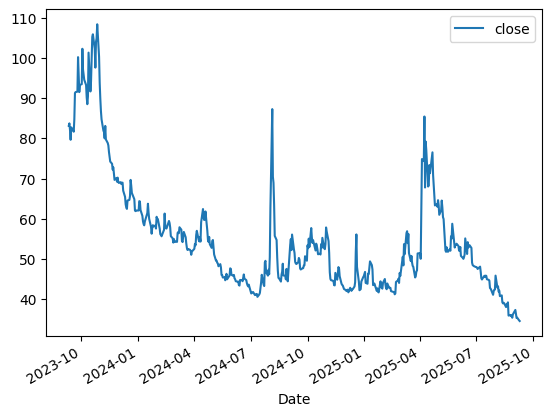

In [3]:
data.plot()

# Step 3. 计算均线 & 生成交易信号

In [4]:
# 计算10日和30日均线
data["ma10"] = data["close"].rolling(10).mean()
data["ma30"] = data["close"].rolling(30).mean()

# 生成信号：-1=做空, 0=空仓
data["signal"] = 0
data.loc[data["ma10"] < data["ma30"], "signal"] = -1  # 短均线在下 → 做空
data.loc[data["ma10"] >= data["ma30"], "signal"] = 0  # 短均线在上 → 空仓

# 检查部分信号
data.tail(15)


,close,ma10,ma30,signal
Date,,,,
2025-08-19,38.820000,39.941,42.686000,-1
2025-08-20,38.669998,39.615,42.466333,-1
2025-08-21,39.270000,39.321,42.277000,-1
2025-08-22,35.980000,38.838,41.969667,-1
2025-08-25,36.139999,38.352,41.645333,-1
2025-08-26,35.860001,38.008,41.320333,-1
2025-08-27,36.009998,37.707,40.990333,-1
2025-08-28,35.450001,37.334,40.643667,-1
2025-08-29,36.270000,37.057,40.352333,-1


# Step 4. 计算每日收益 & 策略净值

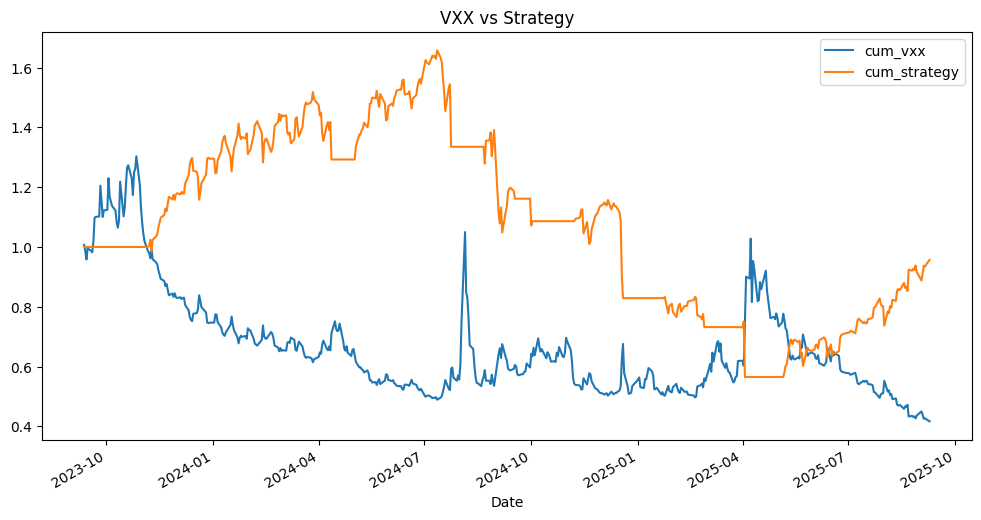

In [5]:
# VXX 日度收益率
data["ret"] = data["close"].pct_change()

# 策略收益 = 信号 * VXX收益 （注意：做空时信号 = -1）
data["strategy_ret"] = data["signal"].shift(1) * data["ret"]

# 累积净值
data["cum_vxx"] = (1 + data["ret"]).cumprod()
data["cum_strategy"] = (1 + data["strategy_ret"]).cumprod()

data[["cum_vxx", "cum_strategy"]].plot(figsize=(12,6), title="VXX vs Strategy")
plt.show()


# Step 5. 回测绩效指标

In [6]:
def performance_stats(returns, freq=252):
    cum_return = (1 + returns).prod() - 1
    ann_return = (1 + cum_return) ** (freq / len(returns)) - 1
    ann_vol = returns.std() * (freq ** 0.5)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    drawdown = ( (1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min()
    return {
        "Cumulative Return": cum_return,
        "Annualized Return": ann_return,
        "Annualized Vol": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown
    }

stats = performance_stats(data["strategy_ret"].dropna())
stats


{'Cumulative Return': np.float64(-0.043331655206747866),
 'Annualized Return': np.float64(-0.02207905583182701),
 'Annualized Vol': np.float64(0.4560877573150696),
 'Sharpe Ratio': np.float64(-0.04840966563497252),
 'Max Drawdown': np.float64(-0.6591647678992705)}

# Step 6. 可视化交易信号

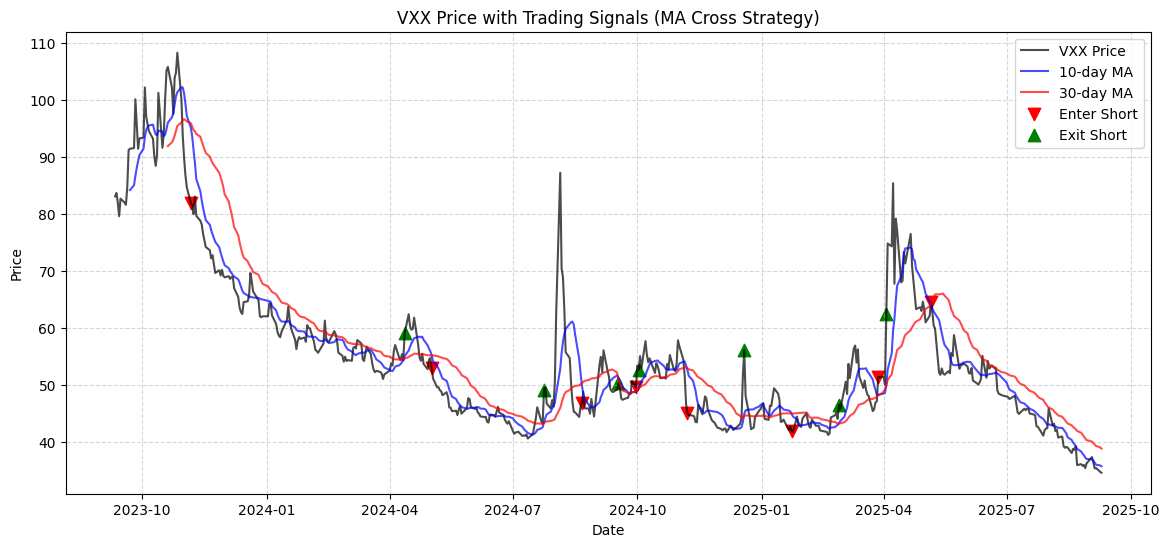

In [7]:
plt.figure(figsize=(14,6))
plt.plot(data.index, data["close"], label="VXX Price", color="black", alpha=0.7)
plt.plot(data.index, data["ma10"], label="10-day MA", color="blue", alpha=0.7)
plt.plot(data.index, data["ma30"], label="30-day MA", color="red", alpha=0.7)

# 做空信号点（10日均线下穿30日均线）
short_signals = (data["signal"] == -1) & (data["signal"].shift(1) == 0)
plt.scatter(data.index[short_signals], data["close"][short_signals],
            marker="v", color="red", label="Enter Short", s=80)

# 平仓信号点（10日均线上穿30日均线）
exit_signals = (data["signal"] == 0) & (data["signal"].shift(1) == -1)
plt.scatter(data.index[exit_signals], data["close"][exit_signals],
            marker="^", color="green", label="Exit Short", s=80)

plt.title("VXX Price with Trading Signals (MA Cross Strategy)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# Step 7. 输出交易明细

In [8]:
trades = []

# 遍历信号，找到进场(-1)和平仓(0)
position = 0
entry_date, entry_price = None, None

for date, row in data.iterrows():
    signal = row["signal"]
    price = row["close"]

    # 开仓：从0 -> -1
    if position == 0 and signal == -1:
        position = -1
        entry_date = date
        entry_price = price

    # 平仓：从-1 -> 0
    elif position == -1 and signal == 0:
        position = 0
        exit_date = date
        exit_price = price
        ret = (entry_price - exit_price) / entry_price  # 做空收益率
        trades.append({
            "Entry Date": entry_date,
            "Entry Price": entry_price,
            "Exit Date": exit_date,
            "Exit Price": exit_price,
            "Holding Days": (exit_date - entry_date).days,
            "Return %": round(ret * 100, 2)
        })

# 转为DataFrame查看
trades_df = pd.DataFrame(trades)
trades_df


,Entry Date,Entry Price,Exit Date,Exit Price,Holding Days,Return %
0,2023-11-06,81.919998,2024-04-12,59.160000,158,27.78
1,2024-05-02,52.959999,2024-07-24,49.189999,83,7.12
2,2024-08-21,46.889999,2024-09-17,50.299999,27,-7.27
3,2024-09-30,49.599998,2024-10-02,52.709999,2,-6.27
4,2024-11-07,45.090000,2024-12-19,56.139999,42,-24.51
5,2025-01-23,41.930000,2025-02-27,46.570000,35,-11.07
6,2025-03-28,51.419998,2025-04-03,62.490002,6,-21.53
